In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles,venn3,venn3_circles
import seaborn as sns
import matplotlib
import matplotlib as mpl
mpl.rcParams['font.serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [11]:
a = pd.read_csv('../../map_drugs/clinicaltrial.csv')

In [13]:
a['Clinical_phase'].value_counts()

4.0    204
0.0    109
3.0     48
2.0     36
1.0      7
Name: Clinical_phase, dtype: int64

In [17]:
204/397

0.5138539042821159

## fig 2a

In [13]:
tables7 = pd.read_excel('../../tables/Table S7.xlsx')

In [14]:
crispr = tables7[tables7['Host Gene Type']=='CRISPR-Screening']['Host Gene'].unique()
ppi = tables7[tables7['Host Gene Type']=='PPI']['Host Gene'].unique()
gwas = tables7[tables7['Host Gene Type']=='GWAS']['Host Gene'].unique()

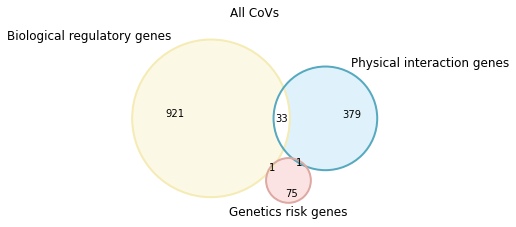

In [18]:
f, ax = plt.subplots(figsize=(5, 5))
g = venn3([set(crispr), set(ppi), set(gwas)],
          ax=ax,
          set_colors=['#F8EFC1', '#B1DEF3','#F9BABA'],
          set_labels=['Biological regulatory genes', 'Physical interaction genes','Genetics risk genes'])
v = venn3_circles(
    [set(crispr), set(ppi), set(gwas)],
    ax=ax,
)
v[0].set_edgecolor('#F5EBB4')
v[1].set_edgecolor('#57A9BF')
v[2].set_edgecolor('#DDA9A2')
ax.set_title('All CoVs')
f.savefig('./fig2a.pdf')

## fig2b

In [3]:
tables7 = pd.read_excel('../../tables/Table S7.xlsx')
sarscov2 = tables7[tables7['Virus']=='SARS-CoV-2']

In [4]:
crispr = sarscov2[sarscov2['Host Gene Type']=='CRISPR-Screening']['Host Gene'].unique()
ppi = sarscov2[sarscov2['Host Gene Type']=='PPI']['Host Gene'].unique()
gwas = sarscov2[sarscov2['Host Gene Type']=='GWAS']['Host Gene'].unique()

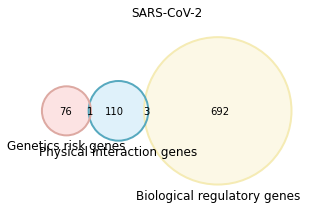

In [5]:
f, ax = plt.subplots(figsize=(5, 5))
g = venn3([set(crispr), set(ppi), set(gwas)],
          ax=ax,
          set_colors=['#F8EFC1', '#B1DEF3','#F9BABA'],
          set_labels=['Biological regulatory genes', 'Physical interaction genes','Genetics risk genes'])
v = venn3_circles(
    [set(crispr), set(ppi), set(gwas)],
    ax=ax,
)
v[0].set_edgecolor('#F5EBB4')
v[1].set_edgecolor('#57A9BF')
v[2].set_edgecolor('#DDA9A2')
ax.set_title('SARS-CoV-2')
f.savefig('./fig2b.pdf')

In [6]:
set(crispr)&set(ppi)

{'DTYMK', 'SLC4A4', 'TIMM10'}

In [8]:
set(ppi)&set(gwas)

{'BMPR2'}

In [9]:
76+1+110+3+692

882

## fig 2c

In [53]:
tables7 = pd.read_excel('../../tables/Table S7.xlsx')

In [54]:
tables7.to_csv('./fig2c_edge.csv',index=False)
# tables1['Host Gene'] = tables1['Host Gene'].astype(str)
figs1b_node = pd.DataFrame(columns=['name','type','Virus'])
ith = 0
for i in ['SARS-CoV','SARS-CoV-2','MERS-CoV',]:
    figs1b_node.loc[ith] = i,'virus',i
    ith += 1
for gene,sub_df in tables7.sort_values('Virus').groupby('Host Gene'):
    if len(sub_df['Virus'].unique()) > 1:
        figs1b_node.loc[ith] = gene,'gene',';'.join(sub_df['Virus'].unique())
    else:
        figs1b_node.loc[ith] = gene,'gene2',';'.join(sub_df['Virus'].unique())
    ith += 1
figs1b_node.to_csv('./fig2c_node.csv',index=False)

## fig2d

In [26]:
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def get_user_list_id(gene_list):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
    payload = {'list':(None,'\n'.join([str(i) for i in gene_list]))}

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    data = json.loads(response.text)
    user_list_id = data['userListId']
    
    return user_list_id

In [28]:
def get_enrichment_result(user_list_id, gene_set_library='KEGG_2019_Human'):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    response = requests.get(
        f'{ENRICHR_URL}?userListId={user_list_id}&backgroundType={gene_set_library}')
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    result_df = pd.DataFrame(columns=['Rank', 'Term name', 'P-value', 'Z-score', 'Combined score',
                                      'Overlapping genes', 'Adjusted p-value', 'Old p-value',
                                      'Old adjusted p-value'],dtype=object)
    for i, row in enumerate(data[gene_set_library]):
        result_df.loc[i] = row
    return result_df

In [29]:
def plot(df, file_name, palette='Blues'):
    df['-log10P'] = -np.log10(df['Adjusted p-value'])
    sns.set(style="ticks")
    f, ax = plt.subplots(figsize=(5, 10))
    sns.barplot(x="-log10P", y="Term name",
                data=df[:20], palette=palette, ax=ax)
    ax.set_xlabel('-$\mathregular{log_{10}}$P', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    f.savefig(file_name, format='pdf', dpi=300)

In [66]:
tables7 = pd.read_excel('../../tables/Table S7.xlsx')
neg_genes = tables7[tables7['Direction']==-1]['Host Gene'].unique()


In [67]:
gene_list = neg_genes
user_list_id = get_user_list_id(gene_list)
result_df = get_enrichment_result(user_list_id, gene_set_library='KEGG_2021_Human')
result_df['Count'] = result_df['Overlapping genes'].map(len)
result_df['GeneRatio'] = result_df['Count'] /len(gene_list)
result_df = result_df[:10].sort_values('GeneRatio')
result_df['P.adj'] = result_df['Adjusted p-value']

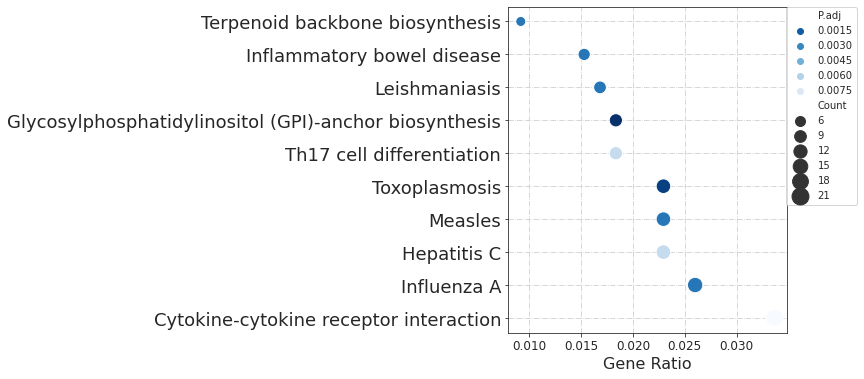

In [74]:
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(5, 6))
sns.scatterplot(
    data=result_df,
    x="GeneRatio",
    y="Term name",
    hue="P.adj",
    size="Count",
    sizes=(100,300),
    ax=ax,
    legend = 'brief',
    palette = 'Blues_r',
)
ax.grid(True,linestyle='-.')
plt.xticks(fontsize=12 )
plt.yticks(fontsize=18 )
ax.set_xlabel('Gene Ratio', fontsize=16)
plt.legend(bbox_to_anchor=(1.25, 1),
           borderaxespad=0,)
ax.set_ylabel('')
f.savefig('./fig2d.pdf')

## fig2e

In [75]:
tables7 = pd.read_excel('../../tables/Table S7.xlsx')
pos_genes = tables7[tables7['Direction']==1]['Host Gene'].unique()

In [76]:
gene_list = pos_genes
user_list_id = get_user_list_id(gene_list)
result_df = get_enrichment_result(user_list_id, gene_set_library='KEGG_2021_Human')
result_df['Count'] = result_df['Overlapping genes'].map(len)
result_df['GeneRatio'] = result_df['Count'] /len(gene_list)
result_df = result_df[:10].sort_values('GeneRatio')
result_df['P.adj'] = result_df['Adjusted p-value']

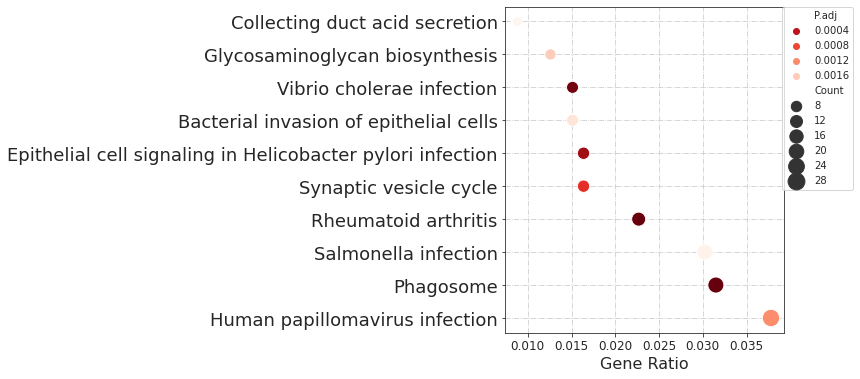

In [78]:
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(5, 6))
sns.scatterplot(
    data=result_df,
    x="GeneRatio",
    y="Term name",
    hue="P.adj",
    size="Count",
    sizes=(100,300),
    ax=ax,
    legend = 'brief',
    palette = 'Reds_r',
)
ax.grid(True,linestyle='-.')
plt.xticks(fontsize=12 )
plt.yticks(fontsize=18 )
ax.set_xlabel('Gene Ratio', fontsize=16)
plt.legend(bbox_to_anchor=(1.25, 1),
           borderaxespad=0,)
ax.set_ylabel('')
f.savefig('./fig2e.pdf')